In [1]:
# Import packages
import os
import pathlib
import zipfile

import geopandas as gpd
import load_model
import matplotlib.pyplot as plt
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr
from rioxarray.merge import merge_arrays

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'st-vrain-rem-wkdir', 'data')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/st-vrain-rem-wkdir/data does not exist. Creating...


# Load the site information into dictionaries
## Load the LiDAR DTMs

In download and unzip lidar step, - ideally would download from CO hs site, but there is no direct link. I uploaded zip files to git, and had to change the file content names bc otherwise  running into issues unzipping - the extracted files include root directory in filename, and the name is not callable

In [3]:
# Call the function to create dictionaries for the sites.
site_names = ['applevalley', 'hallmeadows', 'hallmeadows2', 'highway93']
site_lidar_urls = load_model.get_lidar_url(site_names=site_names)

In [4]:
# Download and unzip lidar, save the lidar DTMs to the dictionaries
for site in site_lidar_urls:
    site['lidar_dtm'] = load_model.load_dtm(data_url=site['lidar_url'], 
                                     site_name=site['site_name'],
                                     file_name=site['zip_filename'])
# Merge the 2 hallmeadows tiles and replace dtm:
for site in site_lidar_urls:
    if site['site_name'] == 'hallmeadows':
        site['lidar_dtm'] = (merge_arrays(dataarrays = [site_lidar_urls[1]['lidar_dtm'], 
                                                        site_lidar_urls[2]['lidar_dtm']]))
    if site['site_name'] == 'hallmeadows2':
        site_lidar_urls.remove(site)

applevalley does not exist. Creating...
applevalley/applevalley_lidar.zip does not exist. Downloading...
hallmeadows does not exist. Creating...
hallmeadows/hallmeadows_lidar.zip does not exist. Downloading...
hallmeadows2 does not exist. Creating...
hallmeadows2/hallmeadows2_lidar.zip does not exist. Downloading...
highway93 does not exist. Creating...
highway93/highway93_lidar.zip does not exist. Downloading...


## Load the Area of Interest (AOI)

In [5]:
# Call function to create bounding polygon gdf for each site, save to site_lidar_urls
shape_url = ('https://github.com/lechipman/watershed-project/'
                 'releases/download/v2.0.0/shapefiles.zip')

for site in site_lidar_urls:
    site['bounding_polygon'] = (load_model.get_boundary_gdf(
                                data_url=shape_url, 
                                site_name=site['site_name']))

shapefiles.zip does not exist. Downloading...


## Load the UAV DTMs and REMs

In [6]:
# Call function to download the UAV DTMs and REMs and add to dictionary
# Note at this step, the main dictionary name is changes to site_data_dictionary
site_data_dictionary = load_model.get_uav_dtms(site_data_dictionary=site_lidar_urls)

applevalley/applevalley_rem.tif does not exist. Downloading...
applevalley/applevalley_dtm.tif does not exist. Downloading...
hallmeadows/hallmeadows_rem.tif does not exist. Downloading...
hallmeadows/hallmeadows_dtm.tif does not exist. Downloading...
highway93/highway93_rem.tif does not exist. Downloading...
highway93/highway93_dtm.tif does not exist. Downloading...


## Clip the LiDAR and UAV DTMs to the AOI

In [7]:
# Clip the lidar dtm to bounding polygon, convert to meters, and add to dictionary
# Note the dtm.clip function saves the clipped dtm for use in the remmaker
for site in site_data_dictionary:
    site['lidar_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                          site_dtm = site['lidar_dtm'],
                                          clip_gdf = site['bounding_polygon'],
                                          is_lidar=True))*0.3048
# Clip the uav dtm to bounding polygon and add to dictionary
for site in site_data_dictionary:
    site['uav_clipped_dtm'] = (load_model.dtm_clip(site_name = site['site_name'],
                                        site_dtm = site['uav_dtm'],
                                        clip_gdf = site['bounding_polygon'],
                                        is_lidar=False))

## Plot the LiDAR and UAV DTMs

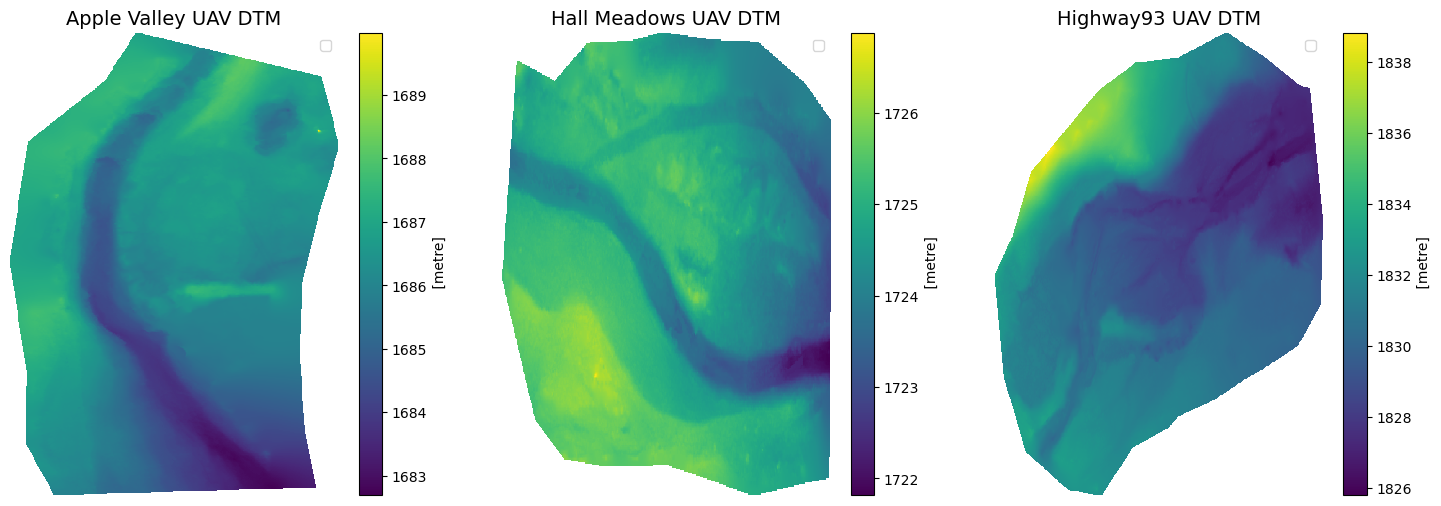

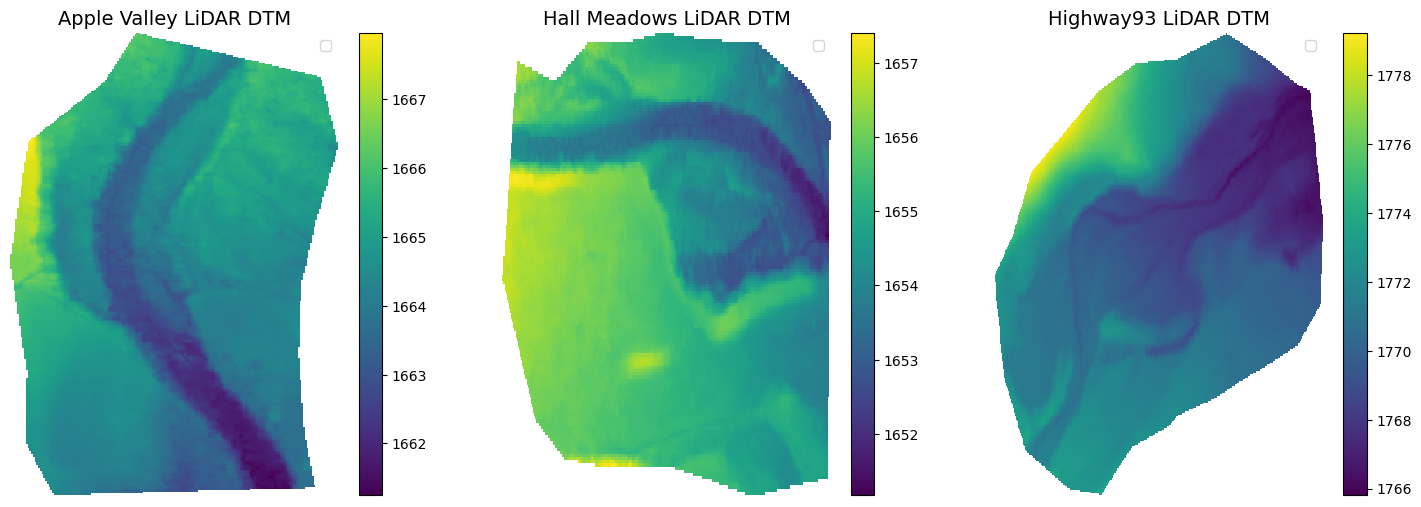

In [8]:
# Call function to plot UAV and Lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley UAV DTM', 
              'Hall Meadows UAV DTM',
              'Highway93 UAV DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_clipped_dtm'], 
                   title=plot_title[i],
                   coarsen=True,
                   xpix=20,
                   ypix=20,
                   ax=axe)
    
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley LiDAR DTM', 
              'Hall Meadows LiDAR DTM',
              'Highway93 LiDAR DTM']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
                   title=plot_title[i],
                   coarsen=False,
                   #xpix=20,
                   #ypix=20,
                   ax=axe)

## To do for steps above

* update plot_model to add colorbar and update binning (try Robust=True?)
* update urls to new zenodo link (some urls are in this file, some are defined in a function in load_model.py)

## Plot the LiDAR and UAV DTM histograms

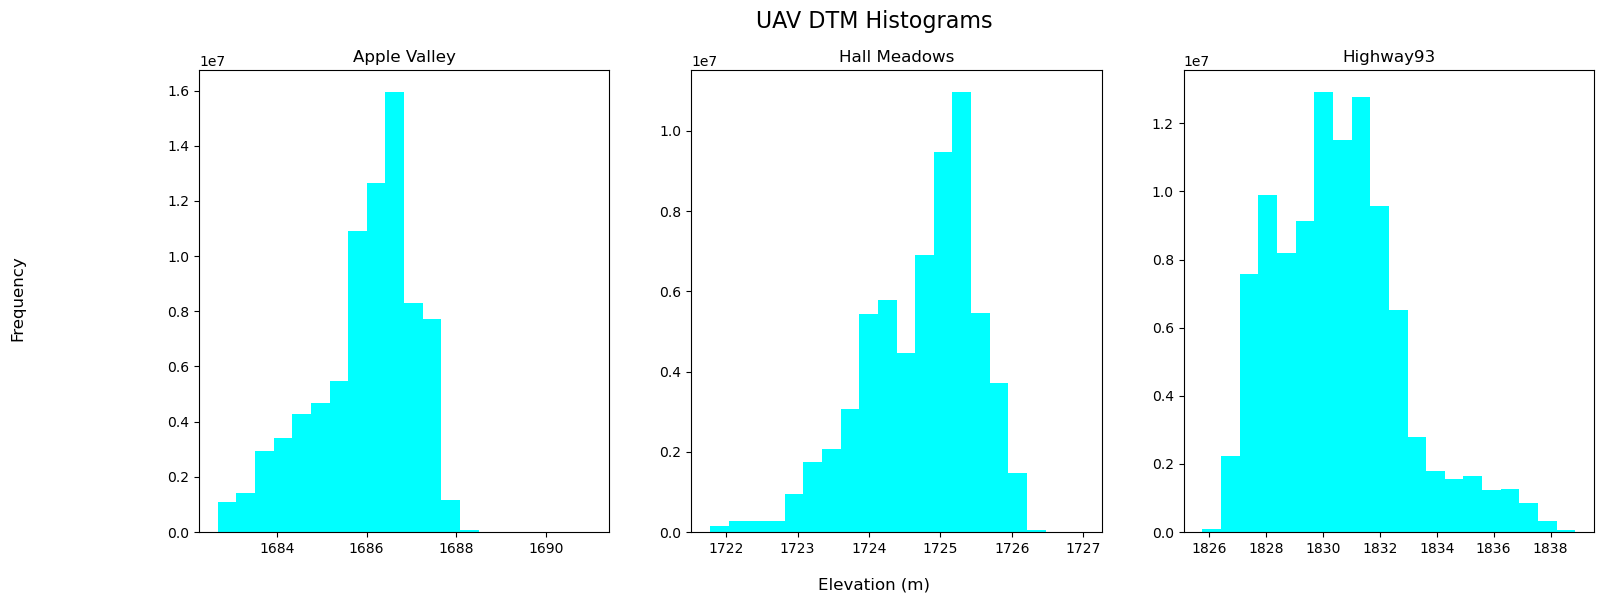

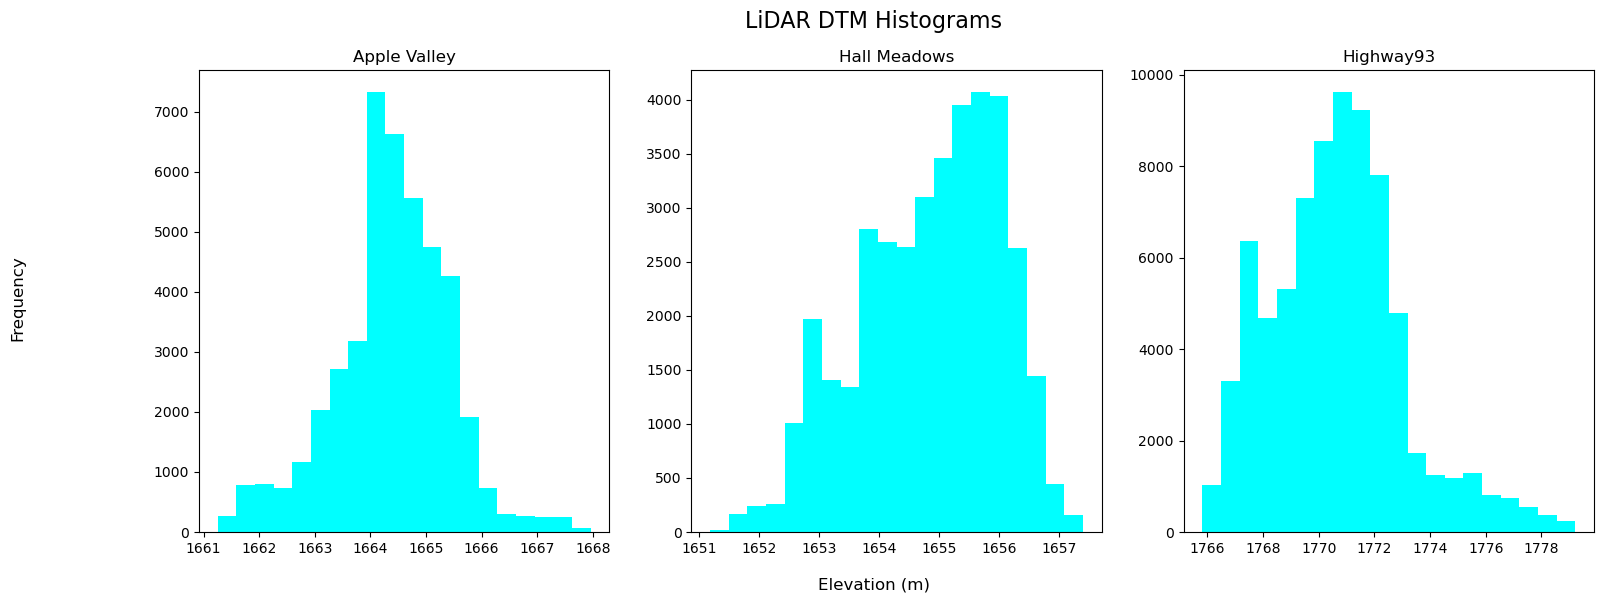

In [9]:
# Call function to plot histogram of lidar and UAV DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_clipped_dtm'], 
               titles=plot_title[i],
               main_title='UAV DTM Histograms',
               color=('cyan'),
               ax=axe, 
               fig=fig)
    
# Call function to plot histogram of lidar DTMs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_clipped_dtm'], 
               titles=plot_title[i],
               main_title='LiDAR DTM Histograms',
               color=('cyan'),
               ax=axe,
               fig=fig)

# Create LiDAR REMs Using REMMaker Tool

In [10]:
# Create LiDAR REMs for all sites with run_rem_maker_lidar function, add to dict
# Note, the run_rem_maker_lidar function set thes directories and paths so that a new
# directory 'rem_maker_lidar' and file ''{}_lidar_dtm_REM.tif' is created
for site in site_data_dictionary:
    load_model.run_rem_maker_lidar(site_name=site['site_name'])
    lidar_rem_path = os.path.join(site['site_name'],
                                  'remmaker_lidar',
                                  '{}_lidar_dtm_REM.tif').format(site['site_name'])
    site['lidar_remmaker'] = rxr.open_rasterio(lidar_rem_path, masked=True)

[INFO] 2023-08-17 23:01:02,607 - Getting DEM projection.
[INFO] 2023-08-17 23:01:02,614 - Reading DEM as array.
[INFO] 2023-08-17 23:01:02,656 - Getting DEM bounds.
[INFO] 2023-08-17 23:01:02,663 - Mapping array indices to coordinates.
[INFO] 2023-08-17 23:01:02,664 - Finding river centerline.


applevalley/remmaker_lidar does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...
Clearing OSM cache.


[INFO] 2023-08-17 23:01:05,531 - Found river(s): North Saint Vrain Creek
[INFO] 2023-08-17 23:01:05,532 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:01:06,312 - 	North Saint Vrain Creek: 0.0027 degree
[INFO] 2023-08-17 23:01:06,313 - 
Longest river in domain: North Saint Vrain Creek

[INFO] 2023-08-17 23:01:06,329 - Making river points shapefile.
[INFO] 2023-08-17 23:01:06,417 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:01:06,428 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:01:06,429 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:01:06,431 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:01:


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/applevalley_lidar_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/applevalley_lidar_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/applevalley_lidar_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved applevalley/remmaker_lidar/applevalley_lidar_dtm_hillshade-color.tif.

Generating .png file.
Saved applevalley/remmaker_lidar/applevalley_lidar_dtm_hillshade-color.png.
hallmeadows/remmaker_lidar does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...
Clearing OSM cache.


[INFO] 2023-08-17 23:01:08,322 - Found river(s): South Saint Vrain Creek
[INFO] 2023-08-17 23:01:08,322 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:01:08,339 - 	South Saint Vrain Creek: 0.0027 degree
[INFO] 2023-08-17 23:01:08,339 - 
Longest river in domain: South Saint Vrain Creek

[INFO] 2023-08-17 23:01:08,354 - Making river points shapefile.
[INFO] 2023-08-17 23:01:08,399 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:01:08,407 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:01:08,408 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:01:08,409 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:01:


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/hallmeadows_lidar_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/hallmeadows_lidar_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/hallmeadows_lidar_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved hallmeadows/remmaker_lidar/hallmeadows_lidar_dtm_hillshade-color.tif.

Generating .png file.
Saved hallmeadows/remmaker_lidar/hallmeadows_lidar_dtm_hillshade-color.png.
highway93/remmaker_lidar does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...
Clearing OSM cache.


[INFO] 2023-08-17 23:01:10,264 - Found river(s): Coal Creek
[INFO] 2023-08-17 23:01:10,265 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:01:10,281 - 	Coal Creek: 0.0037 degree
[INFO] 2023-08-17 23:01:10,281 - 
Longest river in domain: Coal Creek

[INFO] 2023-08-17 23:01:10,296 - Making river points shapefile.
[INFO] 2023-08-17 23:01:10,339 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:01:10,349 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:01:10,350 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:01:10,352 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:01:10,356 - Constructing tree.
[INFO] 2023


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/highway93_lidar_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/highway93_lidar_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/highway93_lidar_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved highway93/remmaker_lidar/highway93_lidar_dtm_hillshade-color.tif.

Generating .png file.
Saved highway93/remmaker_lidar/highway93_lidar_dtm_hillshade-color.png.


## Create UAV REMs Using REMMaker Tool

In [11]:
# Create UAV REMs for all sites with run_rem_maker function, add to dict
# The function creates new directory and file similar to the run_rem_maker_lidar function
for site in site_data_dictionary:
    load_model.run_rem_maker(site_name=site['site_name'], k=100)
    uav_rem_path = os.path.join(site['site_name'],
                                  'remmaker',
                                  '{}_dtm_REM.tif').format(site['site_name'])
    site['uav_remmaker'] = rxr.open_rasterio(uav_rem_path, masked=True)

[INFO] 2023-08-17 23:01:10,946 - Getting DEM projection.
[INFO] 2023-08-17 23:01:10,948 - Reading DEM as array.


applevalley/remmaker does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...


[INFO] 2023-08-17 23:01:11,888 - Getting DEM bounds.
[INFO] 2023-08-17 23:01:11,888 - Mapping array indices to coordinates.
[INFO] 2023-08-17 23:01:11,927 - Finding river centerline.


Clearing OSM cache.


[INFO] 2023-08-17 23:01:13,442 - Found river(s): North Saint Vrain Creek
[INFO] 2023-08-17 23:01:13,443 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:01:13,459 - 	North Saint Vrain Creek: 0.0027 degree
[INFO] 2023-08-17 23:01:13,459 - 
Longest river in domain: North Saint Vrain Creek

[INFO] 2023-08-17 23:01:13,476 - Making river points shapefile.
[INFO] 2023-08-17 23:01:13,521 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:01:16,673 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:01:16,673 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:01:17,917 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:01:


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/applevalley_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/applevalley_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/applevalley_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved applevalley/remmaker/applevalley_dtm_hillshade-color.tif.

Generating .png file.


[INFO] 2023-08-17 23:09:59,794 - Getting DEM projection.
[INFO] 2023-08-17 23:09:59,796 - Reading DEM as array.


Saved applevalley/remmaker/applevalley_dtm_hillshade-color.png.
hallmeadows/remmaker does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...


[INFO] 2023-08-17 23:10:00,474 - Getting DEM bounds.
[INFO] 2023-08-17 23:10:00,475 - Mapping array indices to coordinates.
[INFO] 2023-08-17 23:10:00,517 - Finding river centerline.


Clearing OSM cache.


[INFO] 2023-08-17 23:10:02,102 - Found river(s): South Saint Vrain Creek
[INFO] 2023-08-17 23:10:02,103 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:10:02,131 - 	South Saint Vrain Creek: 0.0027 degree
[INFO] 2023-08-17 23:10:02,132 - 
Longest river in domain: South Saint Vrain Creek

[INFO] 2023-08-17 23:10:02,147 - Making river points shapefile.
[INFO] 2023-08-17 23:10:02,190 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:10:04,495 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:10:04,496 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:10:05,444 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:10:


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/hallmeadows_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/hallmeadows_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/hallmeadows_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved hallmeadows/remmaker/hallmeadows_dtm_hillshade-color.tif.

Generating .png file.


[INFO] 2023-08-17 23:18:48,138 - Getting DEM projection.
[INFO] 2023-08-17 23:18:48,140 - Reading DEM as array.


Saved hallmeadows/remmaker/hallmeadows_dtm_hillshade-color.png.
highway93/remmaker does not exist. Creating...
Creating REMs for your sites. Please be patient, this step may take awhile...


[INFO] 2023-08-17 23:18:49,815 - Getting DEM bounds.
[INFO] 2023-08-17 23:18:49,816 - Mapping array indices to coordinates.
[INFO] 2023-08-17 23:18:49,884 - Finding river centerline.


Clearing OSM cache.


[INFO] 2023-08-17 23:18:51,574 - Found river(s): Coal Creek
[INFO] 2023-08-17 23:18:51,575 - 
River lengths:
/Users/lchipman/opt/miniconda3/envs/earth-analytics-py2/lib/python3.10/site-packages/riverrem/REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-08-17 23:18:51,604 - 	Coal Creek: 0.0037 degree
[INFO] 2023-08-17 23:18:51,604 - 
Longest river in domain: Coal Creek

[INFO] 2023-08-17 23:18:51,620 - Making river points shapefile.
[INFO] 2023-08-17 23:18:51,663 - Getting river elevation at DEM pixels.
[INFO] 2023-08-17 23:18:55,736 - Interpolating river elevation across DEM extent.
[INFO] 2023-08-17 23:18:55,737 - Using k = 100 nearest neighbors.
[INFO] 2023-08-17 23:18:57,404 - Getting coords of points to interpolate.
[INFO] 2023-08-17 23:19:02,757 - Constructing tree.
[INFO] 2023


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/highway93_dtm_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/highway93_dtm_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/highway93_dtm_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved highway93/remmaker/highway93_dtm_hillshade-color.tif.

Generating .png file.
Saved highway93/remmaker/highway93_dtm_hillshade-color.png.


# Plot the UAV and LiDAR Derived REMs

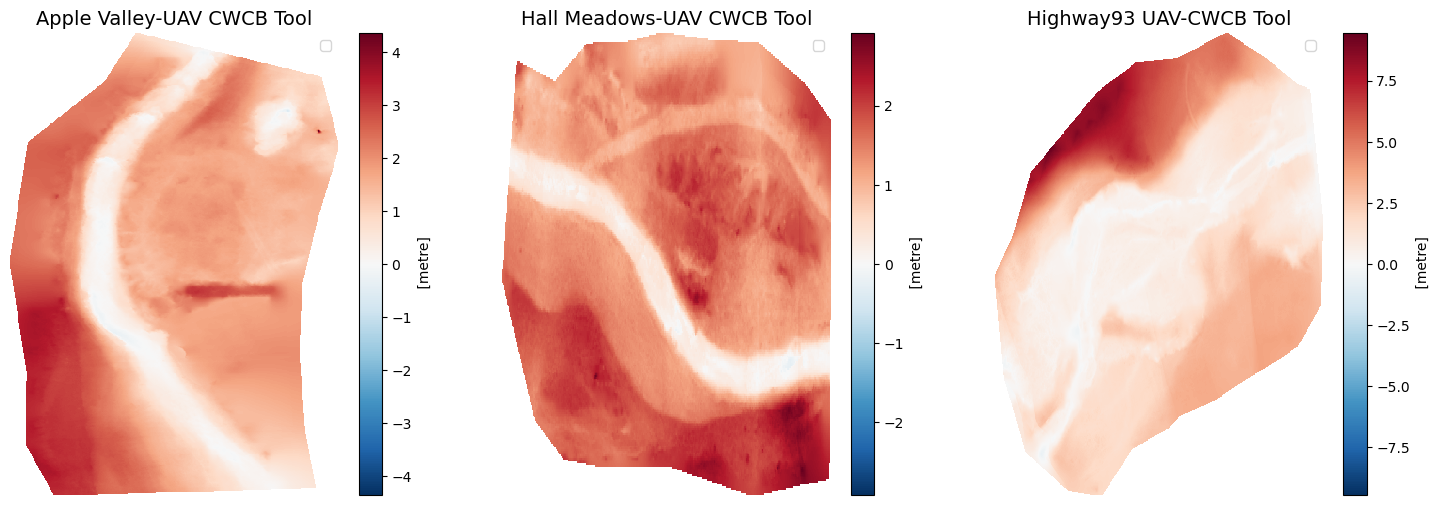

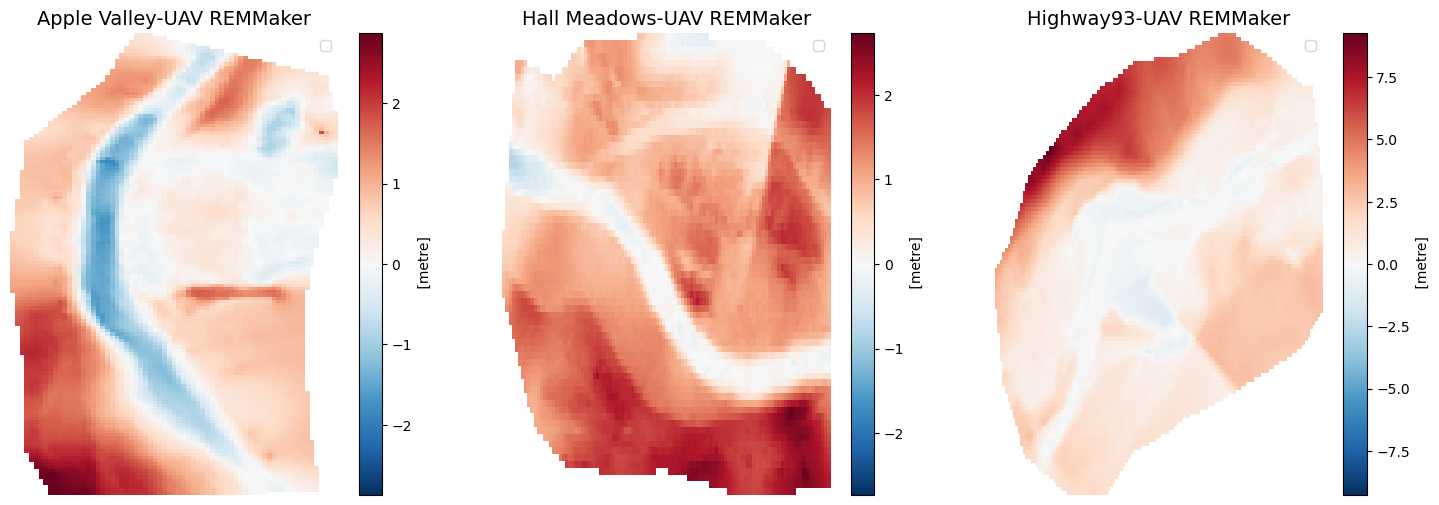

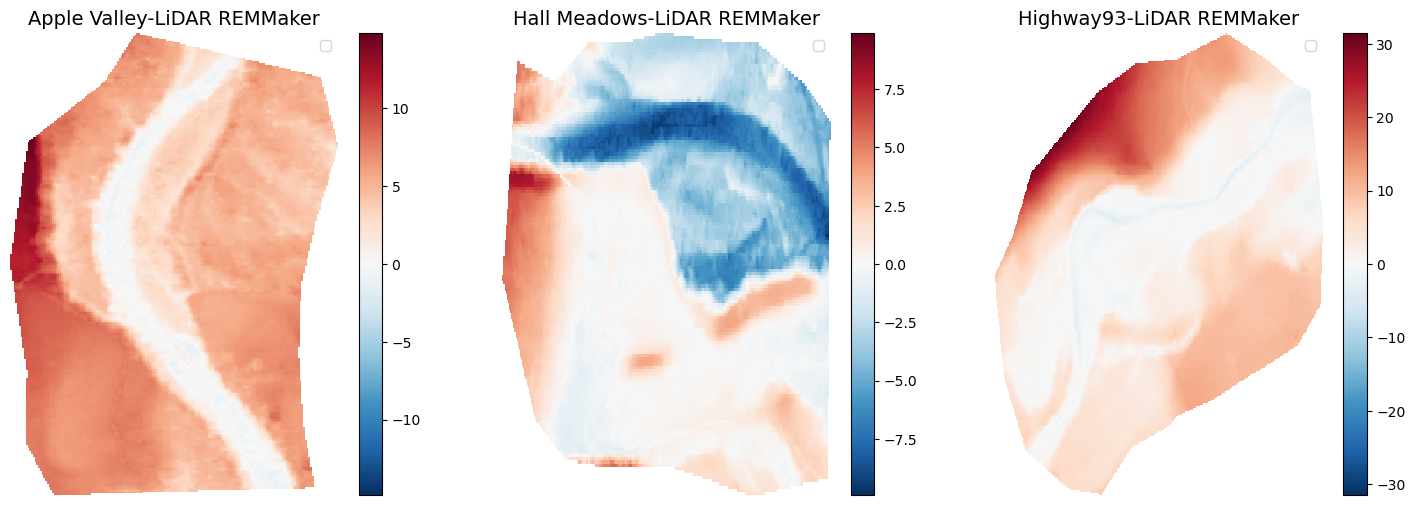

In [12]:
# Call function to plot UAV and LiDAR REMs 
# 1: UAV REMs (CWCB Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-UAV CWCB Tool', 
              'Hall Meadows-UAV CWCB Tool',
              'Highway93 UAV-CWCB Tool']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_rem'], 
                   title=plot_title[i],
                   coarsen=True,
                   xpix=20,
                   ypix=20,
                   ax=axe)

# 2: UAV REMs (REMMaker Tool)
# Note, I didn't rerun REMMaker with the clipped UAV DTM yet, so the REM appears unclipped
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-UAV REMMaker', 
              'Hall Meadows-UAV REMMaker',
              'Highway93-UAV REMMaker']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['uav_remmaker'], 
                   title=plot_title[i],
                   coarsen=True,
                   xpix=100,
                   ypix=100,
                   ax=axe)
    
# 3: Lidar REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley-LiDAR REMMaker', 
              'Hall Meadows-LiDAR REMMaker',
              'Highway93-LiDAR REMMaker']
for i,axe in enumerate(axes.flatten()):
    load_model.plot_model(model=site_data_dictionary[i]['lidar_remmaker'], 
                   title=plot_title[i],
                   coarsen=False,
                   #xpix=100,
                   #ypix=100,
                   ax=axe)

## LiDAR and UAV REMMaker Histograms

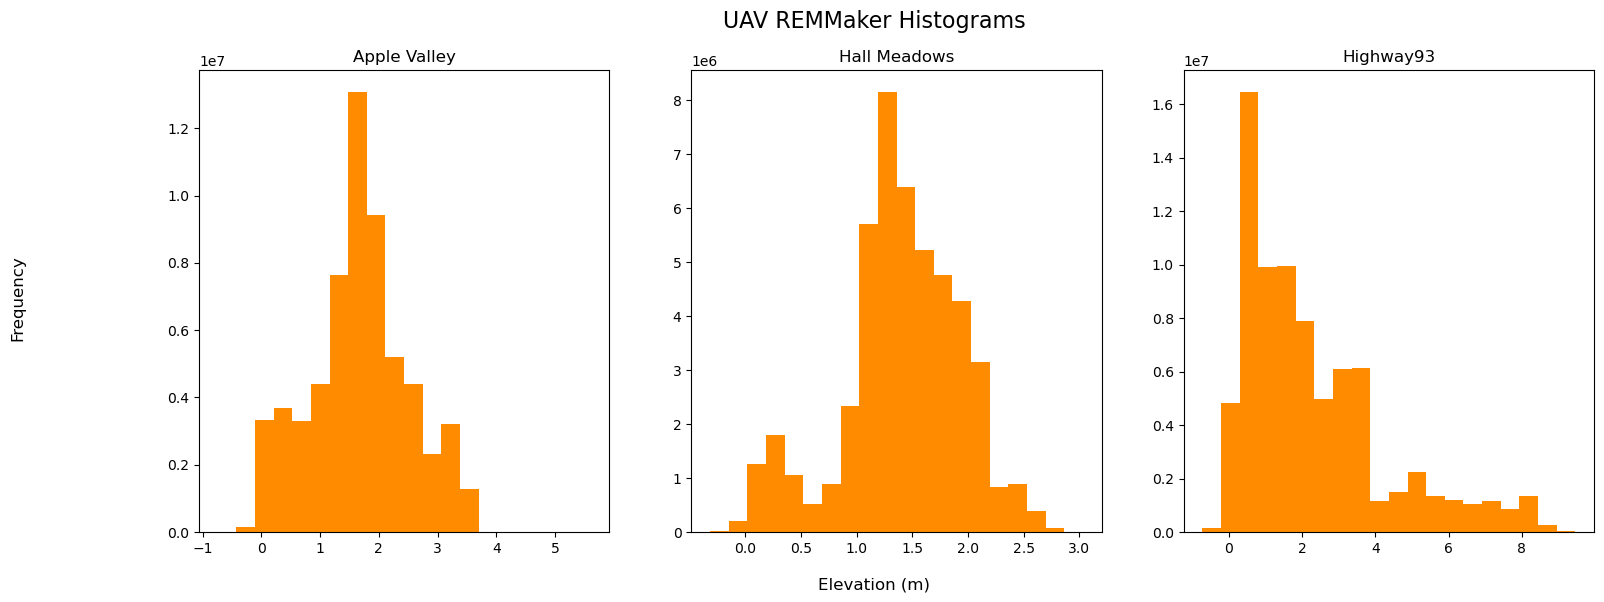

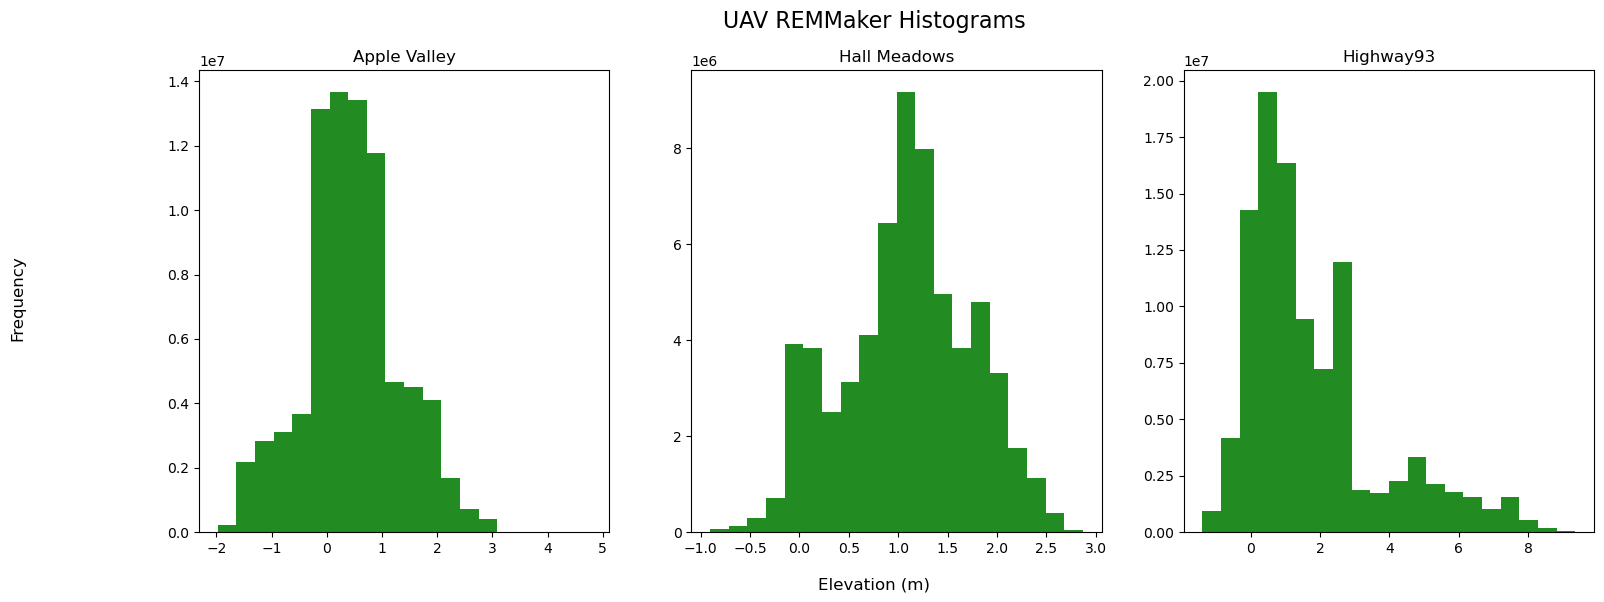

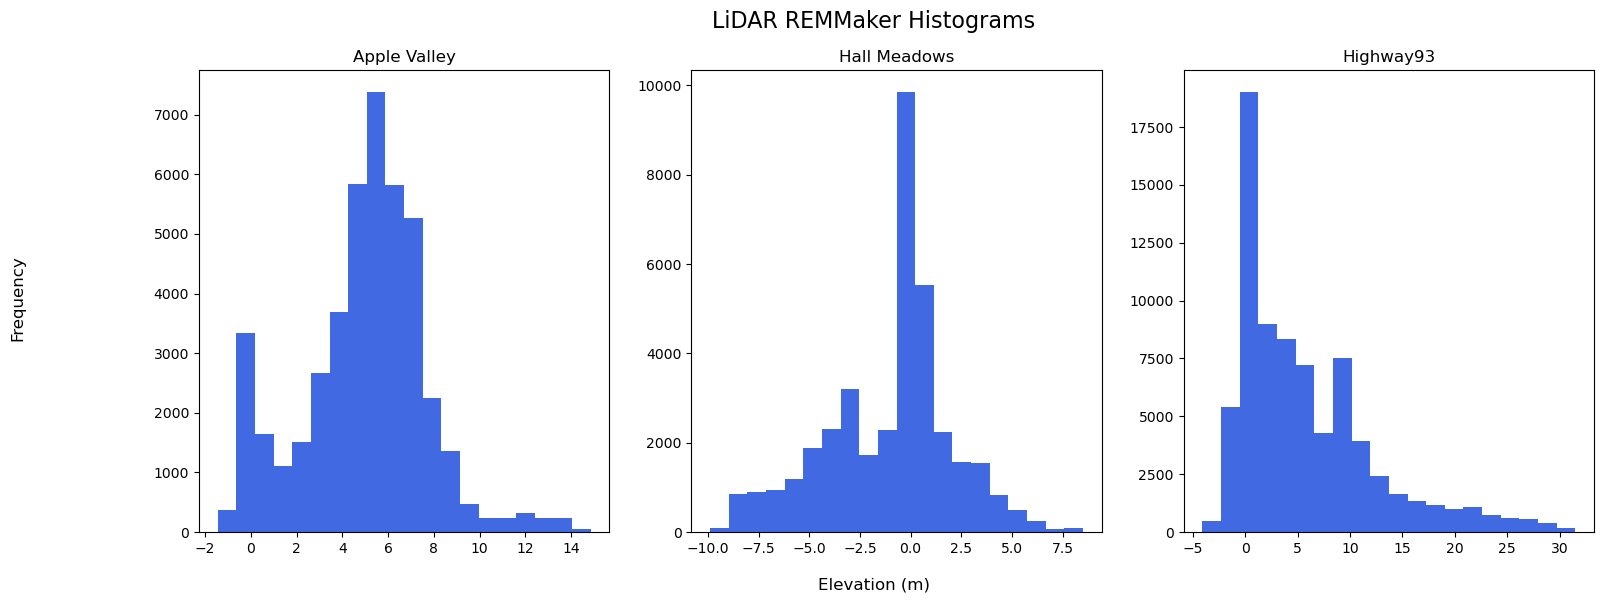

In [13]:
# Call function to plot histograms of LiDAR and UAV REMs
# 1: UAV REMs (CWCB Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_rem'], 
               titles=plot_title[i],
               main_title='UAV REMMaker Histograms',
               color=('darkorange'),
               fig=fig,
               ax=axe)

# 2: UAV REMs (REMMaker Tool)
# Note, I didn't rerun REMMaker with the clipped UAV DTM yet, so the REM appears unclipped
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['uav_remmaker'], 
               titles=plot_title[i],
               main_title='UAV REMMaker Histograms',
               color=('forestgreen'),
               fig=fig,
               ax=axe)
    
# 2: LiDAR REMs (REMMaker Tool)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_title = ['Apple Valley',
              'Hall Meadows',
              'Highway93']

for i, axe in enumerate(axes.flatten()):
    load_model.plot_hists(model=site_data_dictionary[i]['lidar_remmaker'], 
               titles=plot_title[i],
               main_title='LiDAR REMMaker Histograms',
               color=('royalblue'),
               fig=fig,
               ax=axe)

## Flood mapping
* Lindsay is working on this in another file
* set a threshold value that represents flooding level (e.g., anything less than 3ft will be innundated)
* for both the uav and lidar rems, calculate the sum of the #points that are <threshold, and multiply by pixel size - this represents the area flooded
* can loop through several flood levels and compare uav/lidar with a scatter plot of flooded area

In [14]:
# Calculate difference in REMs - need to match resolution
#for site in site_data_dictionary:
#    site['dod_array'] = site['uav_remmaker'] - site['lidar_remmaker']
site_data_dictionary[0]['uav_remmaker']

<xarray.DataArray (band: 1, y: 14287, x: 6993)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 40.24 40.24 40.24 40.24 ... 40.24 40.24 40.24 40.24
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    units:                     metre
    STATISTICS_MAXIMUM:        4.778564453125
    STATISTICS_MEAN:           0.44916622402765
    STATISTICS_MINIMUM:        -1.9775390625
    STATISTICS_STDDEV:         0.85697660582701
    STATISTICS_VALID_PERCENT:  80.16
    scale_factor:              1.0
    add_offset:                0.0

In [15]:
threshhold_das = []
site_data_dictionary[0]['uav_remmaker'].where(site_data_dictionary[0]['uav_remmaker'] < 3)

<xarray.DataArray (band: 1, y: 14287, x: 6993)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 40.24 40.24 40.24 40.24 ... 40.24 40.24 40.24 40.24
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    units:                     metre
    STATISTICS_MAXIMUM:        4.778564453125
    STATISTICS_MEAN:           0.44916622402765
    STATISTICS_MINIMUM:        -1.9775390625
    STATISTICS_STDDEV:         0.85697660582701
    STATISTICS_VALID_PERCENT:  80.16
    scale_factor:              1.0
    add_offset:                0.0